In [1]:
import pandas as pd 
import numpy as np
import cudf , cupy 
import seaborn as sns 
import matplotlib.pyplot as plt
import polars as pl
import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
NAN_VALUE = -100

def read_file(path , usecols = None):
    if usecols is not None : df = cudf.read_parquet(path , columns = usecols)
    else: df = cudf.read_parquet(path)
        
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df['S_2'] = cudf.to_datetime(df['S_2'])
    
    df = df.fillna(NAN_VALUE)
        
    return df 

In [3]:
TRAIN_PATH = '/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet'
train_df = read_file(TRAIN_PATH)

train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,-100.0,0,0.000610,0
1,-4532153018459703766,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,-100.0,0,0.005492,0
2,-4532153018459703766,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,-100.0,0,0.006986,0
3,-4532153018459703766,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,-100.0,0,0.006527,0
4,-4532153018459703766,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,-100.0,0,0.008126,0


In [4]:
%%time
train_df.info(verbose = True , memory_usage = True , null_counts = True)

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 190 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   customer_ID  5531451 non-null  int64
 1   S_2          5531451 non-null  datetime64[ns]
 2   P_2          5531451 non-null  float32
 3   D_39         5531451 non-null  int16
 4   B_1          5531451 non-null  float32
 5   B_2          5531451 non-null  float32
 6   R_1          5531451 non-null  float32
 7   S_3          5531451 non-null  float32
 8   D_41         5531451 non-null  float32
 9   B_3          5531451 non-null  float32
 10  D_42         5531451 non-null  float32
 11  D_43         5531451 non-null  float32
 12  D_44         5531451 non-null  int8
 13  B_4          5531451 non-null  int16
 14  D_45         5531451 non-null  float32
 15  B_5          5531451 non-null  float32
 16  R_2          5531451 non-null  int8
 17  D_46         5531451 non-null  float32
 18  D_47    

In [5]:
train_labels = cudf.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv')
print(train_labels['customer_ID'].nunique(), train_labels.shape)

458913 (458913, 2)


In [6]:
def process_and_feature_engineer(dataframe):
    cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    numeric_features = [col for col in dataframe.columns if col not in (cat_features + ['customer_ID','S_2'])]
    
    categorical_data = dataframe.groupby('customer_ID')[cat_features].agg(['count','nunique','last'])
    categorical_data.columns = ['_'.join(x) for x in categorical_data.columns]
    
    numerical_data = dataframe.groupby('customer_ID')[numeric_features].agg(['mean','min','max','std','median','last'])
    numerical_data.columns = ['_'.join(x) for x in numerical_data.columns]
    
    df = cudf.concat([categorical_data,numerical_data],axis = 1)

    return df

In [7]:
train = process_and_feature_engineer(train_df)
train.head()

,B_30_count,B_30_nunique,B_30_last,B_38_count,B_38_nunique,B_38_last,D_114_count,D_114_nunique,D_114_last,D_116_count,...,D_144_max,D_144_std,D_144_median,D_144_last,D_145_mean,D_145_min,D_145_max,D_145_std,D_145_median,D_145_last
customer_ID,,,,,,,,,,,,,,,,,,,,,
-9223358381327749917,13,2,0,13,3,7,13,1,1,13,...,0.008836,0.002326,0.005299,0.006902,0.000000,0,0,0.000000,0.0,0
-9223193039457028513,13,1,0,13,1,1,13,1,1,13,...,0.009928,0.003128,0.004920,0.000551,0.000000,0,0,0.000000,0.0,0
-9223189665817919541,13,1,0,13,1,1,13,1,0,13,...,1.342109,0.356547,1.282928,0.003858,1.615385,0,2,0.650444,2.0,0
-9223188534444851899,13,1,0,13,1,1,13,1,0,13,...,0.009731,0.002934,0.004397,0.000559,0.000000,0,0,0.000000,0.0,0
-9223173911659837606,13,1,1,13,2,7,13,2,1,13,...,0.008658,0.002931,0.005197,0.007221,0.000000,0,0,0.000000,0.0,0


In [8]:
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')

display(targets)
train = train.merge(targets, left_index=True, right_index=True, how='left')

train.target = train.target.astype('int8')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()

# FEATURES
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

,target
customer_ID,
-4532153018459703766,0
-6696652885210834715,0
7128959966677571777,0
6537921148391624412,0
2065103583825424365,0
...,...
1903558268166310647,0
-1894470643263274362,0
-1275326876387926026,0


There are 1095 features!


In [9]:
FEATURES 

Index(['B_30_count', 'B_30_nunique', 'B_30_last', 'B_38_count', 'B_38_nunique',
       'B_38_last', 'D_114_count', 'D_114_nunique', 'D_114_last',
       'D_116_count',
       ...
       'D_144_max', 'D_144_std', 'D_144_median', 'D_144_last', 'D_145_mean',
       'D_145_min', 'D_145_max', 'D_145_std', 'D_145_median', 'D_145_last'],
      dtype='object', length=1095)

In [10]:
train.columns

Index(['customer_ID', 'B_30_count', 'B_30_nunique', 'B_30_last', 'B_38_count',
       'B_38_nunique', 'B_38_last', 'D_114_count', 'D_114_nunique',
       'D_114_last',
       ...
       'D_144_std', 'D_144_median', 'D_144_last', 'D_145_mean', 'D_145_min',
       'D_145_max', 'D_145_std', 'D_145_median', 'D_145_last', 'target'],
      dtype='object', length=1097)

In [11]:
train['target'].value_counts()

0    340085
1    118828
Name: target, dtype: int32

In [12]:
train.head()

,customer_ID,B_30_count,B_30_nunique,B_30_last,B_38_count,B_38_nunique,B_38_last,D_114_count,D_114_nunique,D_114_last,...,D_144_std,D_144_median,D_144_last,D_145_mean,D_145_min,D_145_max,D_145_std,D_145_median,D_145_last,target
0,-9223358381327749917,13,2,0,13,3,7,13,1,1,...,0.002326,0.005299,0.006902,0.000000,0,0,0.000000,0.0,0,1
1,-9223193039457028513,13,1,0,13,1,1,13,1,1,...,0.003128,0.004920,0.000551,0.000000,0,0,0.000000,0.0,0,0
2,-9223189665817919541,13,1,0,13,1,1,13,1,0,...,0.356547,1.282928,0.003858,1.615385,0,2,0.650444,2.0,0,0
3,-9223188534444851899,13,1,0,13,1,1,13,1,0,...,0.002934,0.004397,0.000559,0.000000,0,0,0.000000,0.0,0,0
4,-9223173911659837606,13,1,1,13,2,7,13,2,1,...,0.002931,0.005197,0.007221,0.000000,0,0,0.000000,0.0,0,1


# Training

In [13]:
import xgboost as xgb 
from sklearn.model_selection import KFold

seed = 42 
xgb_params = {
    'max_depth' : 6,
    'learning_rate':0.1,
    'subsample' : 0.8,
    'colsample_bytree' : 0.6,
    'eval_metric' : 'logloss',
    'objective' : 'binary:logistic',
    'tree_method' : 'gpu_hist',
    'predictor' : 'gpu_predictor',
    'random_state' : seed
}

In [14]:
class IterLoadMatrix(xgb.core.DataIter):
    def __init__(self , df , features , target , batch_size = 256*1024):
        self.features = features
        self.target = target
        self.it = 0
        self.df = df
        self.batch_size = batch_size
        self.batches = np.ceil(len(df)/batch_size)
        super(IterLoadMatrix,self).__init__()
    
    def reset(self):
        self.it = 0
    
    def next(self,input_data):
        if self.it == self.batches:
            return 0
        
        a = self.it * self.batch_size
        b = min((self.it+1)*self.batch_size , len(self.df))
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data = dt[self.features] , label = dt[self.target])
        self.it += 1
        return 1

In [15]:
def amex_metric(y_true: cudf.DataFrame, y_pred: cudf.DataFrame) -> float:

    def top_four_percent_captured(y_true: cudf.DataFrame, y_pred: cudf.DataFrame) -> float:
        df = (cudf.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: cudf.DataFrame, y_pred: cudf.DataFrame) -> float:
        df = (cudf.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: cudf.DataFrame, y_pred: cudf.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [16]:
train.loc[(1,2,3),'target']

1    0
2    0
3    0
Name: target, dtype: int8

In [17]:
FOLDS = 5

importances = []
oof = []
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits = FOLDS , shuffle = True , random_state = seed)

for fold , (train_idx , val_idx) in enumerate(skf.split(train , train['target'])):
    print(f'Fold : {fold}')
    print(f'Training with {len(train_idx)} Train data , {len(val_idx)} Validation data ')
    Xy_train = IterLoadMatrix(train.loc[train_idx] , FEATURES  , 'target')
    X_val = train.loc[val_idx , FEATURES]
    Y_val = train.loc[val_idx , 'target']
    
    d_train = xgb.DeviceQuantileDMatrix(Xy_train , max_bin = 256)
    d_valid = xgb.DMatrix(data = X_val , label = Y_val)
    
    model = xgb.train(xgb_params , dtrain = d_train , evals = [(d_train , 'train') , (d_valid , 'Val')] ,
                     num_boost_round = 8000 , verbose_eval = 100 , early_stopping_rounds = 100)
    model.save_model(f'XGB_Fold_{fold}.xgb')
    
    dd = model.get_score(importance_type = 'weight')
    df = pd.DataFrame({'features' : dd.keys() , f'importance_{fold}' : dd.values()})
    importances.append(df)
    
    oof_predictions = model.predict(d_valid)
    Y_predict = cudf.DataFrame({'prediction' : oof_predictions})
    Y_valid = cudf.DataFrame({'target' : Y_val.values})
    acc = amex_metric( Y_valid , Y_predict )
    print("Kaggle Metric : " , acc)
    
    df = train.loc[val_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_predictions
    oof.append( df )
    
    del d_train, Xy_train, dd, df , Y_predict , Y_valid
    del X_val, Y_val, d_valid, model
    _ = gc.collect()
    
    

Fold : 0
Training with 367130 Train data , 91783 Validation data 
[0]	train-logloss:0.63046	Val-logloss:0.63075
[100]	train-logloss:0.20626	Val-logloss:0.22356
[200]	train-logloss:0.18841	Val-logloss:0.21993
[300]	train-logloss:0.17519	Val-logloss:0.21931
[400]	train-logloss:0.16375	Val-logloss:0.21905
[476]	train-logloss:0.15568	Val-logloss:0.21915
Kaggle Metric :  0.7886150966856967
Fold : 1
Training with 367130 Train data , 91783 Validation data 
[0]	train-logloss:0.63051	Val-logloss:0.63057
[100]	train-logloss:0.20673	Val-logloss:0.22156
[200]	train-logloss:0.18928	Val-logloss:0.21855
[300]	train-logloss:0.17602	Val-logloss:0.21796
[400]	train-logloss:0.16415	Val-logloss:0.21814
[415]	train-logloss:0.16251	Val-logloss:0.21810
Kaggle Metric :  0.7880444585204647
Fold : 2
Training with 367130 Train data , 91783 Validation data 
[0]	train-logloss:0.63047	Val-logloss:0.63080
[100]	train-logloss:0.20581	Val-logloss:0.22479
[200]	train-logloss:0.18796	Val-logloss:0.22181
[300]	train-logl

In [18]:
oof[0]

,customer_ID,target,oof_pred
6,-9223121653379786464,0,0.115512
24,-9222390805238963484,0,0.054644
26,-9222177530103614780,0,0.003018
30,-9222086831790326901,1,0.970502
31,-9222071809949325704,1,0.993240
...,...,...,...
458896,9222682064468139546,1,0.011888
458909,9223300670094807586,1,0.963775
458910,9223303087902649707,1,0.873732
458911,9223345210145379887,0,0.003268


In [19]:
oof_final = cudf.concat(oof , axis = 0 , ignore_index = True).set_index('customer_ID') 
oof_final.rename(columns = {'prediction' : 'oof_pred'})

a = cudf.DataFrame({'prediction' : oof_final['oof_pred'].values})
b = cudf.DataFrame({'target' : oof_final['target'].values}) 

acc = amex_metric(b,a)
print("Kaggle Metric : " , acc)

Kaggle Metric :  0.7880162001300434


In [20]:
oof_final.shape

(458913, 2)

*All training customer ID's are there in oof final*

# Save OOF Predictions 

In [21]:
TRAIN_PATH = '/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet'
oof_xgb = cudf.read_parquet(TRAIN_PATH , columns = ['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].str[-16:].str.hex_to_int().astype('int64')

oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof_final , left_index = True , right_index = True)
oof_xgb = oof_xgb.sort_index().reset_index(drop = True)
oof_xgb.to_csv('oof_predictions.csv',index = False)

oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.596809
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000330
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.001848
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.010099
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.797651


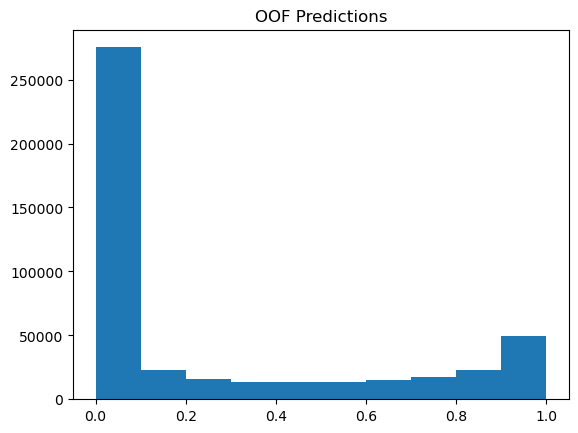

In [23]:
val = oof_xgb['oof_pred'].values
val = cupy.asnumpy(val)

plt.hist(val)
plt.title('OOF Predictions')
plt.savefig('oof.png')
plt.show()

# Feature Importance

In [24]:
df = importances[0]
for k in range(1,FOLDS):
    df = df.merge(importances[k] , on = 'features' ,how = 'left')
    
df.head()

,features,importance_0,importance_1,importance_2,importance_3,importance_4
0,B_30_count,2.0,2.0,1.0,1.0,NaN
1,B_30_nunique,3.0,7.0,4.0,5.0,7.0
2,B_30_last,1.0,1.0,NaN,2.0,5.0
3,B_38_count,1.0,NaN,1.0,1.0,NaN
4,B_38_nunique,8.0,3.0,4.0,5.0,13.0


In [25]:
df['importance'] = df.iloc[:,1:].mean(axis = 1)
df = df.sort_values('importance',ascending = False)

df.head()

,features,importance_0,importance_1,importance_2,importance_3,importance_4,importance
28,P_2_last,166.0,161.0,177.0,179.0,182.0,173.0
34,D_39_last,162.0,153.0,157.0,172.0,174.0,163.6
94,B_4_last,133.0,126.0,133.0,130.0,143.0,133.0
70,B_3_last,133.0,143.0,119.0,122.0,132.0,129.8
92,B_4_std,135.0,129.0,108.0,129.0,129.0,126.0


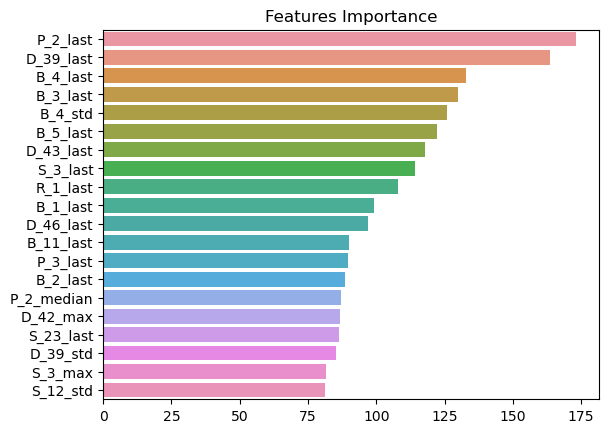

In [26]:
sns.barplot(x = df.importance.values[:20] , y = df.features.values[:20])
plt.title('Features Importance')
plt.savefig('featureimportance.png')
plt.show()

# Infer Test

In [ ]:
def get_rows(customers, test, NUM_PARTS = 5, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
TEST_PATH = '../input/amex-data-integer-dtypes-parquet-format/test.parquet'

print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

In [ ]:
FOLDS = 5
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    
    test = process_and_feature_engineer(test)
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    FEATURES = [col for col in test.columns if col not in ['customer_ID']]
    print(len(FEATURES))
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    del X_test
    gc.collect()

    model = xgb.Booster()
    model.load_model(f'XGB_Fold_0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_Fold_{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    del dtest, model
    _ = gc.collect()

# Create Submission 

In [ ]:
test_preds = np.concatenate(test_preds)
test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

sub.to_csv(f'submission_xgb.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

In [ ]:
plt.hist(cupy.asnumpy(sub['prediction'].values))
plt.title('Submission Distribution')
plt.savefig('submission.png')
plt.show()